In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

# Set style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

# Load data
train_data = pd.read_csv('../data/processed/train_features.csv')
test_predictions = pd.read_csv('../data/processed/test_predictions.csv')
products = pd.read_csv('../data/raw/products.csv')
aisles = pd.read_csv('../data/raw/aisles.csv')
departments = pd.read_csv('../data/raw/departments.csv')
orders = pd.read_csv('../data/raw/orders.csv')
order_products_prior = pd.read_csv('../data/raw/order_products__prior.csv')

print("✓ All data loaded")
print(f"Train data: {train_data.shape}")
print(f"Test predictions: {test_predictions.shape}")
print(f"Products: {products.shape}")

✓ All data loaded
Train data: (8474661, 17)
Test predictions: (4833292, 3)
Products: (49688, 4)


In [3]:
# Merge predictions with product details
test_predictions_full = test_predictions.merge(products, on='product_id')
test_predictions_full = test_predictions_full.merge(aisles, on='aisle_id')
test_predictions_full = test_predictions_full.merge(departments, on='department_id')

print(f"Predictions with details: {test_predictions_full.shape}")
print(f"\nColumns: {test_predictions_full.columns.tolist()}")
print(f"\nSample:")
print(test_predictions_full.head())

# Also merge train data with product details for analysis
train_with_products = train_data.merge(products, on='product_id')
train_with_products = train_with_products.merge(aisles, on='aisle_id')
train_with_products = train_with_products.merge(departments, on='department_id')

print(f"\nTrain with product details: {train_with_products.shape}")

Predictions with details: (4833292, 8)

Columns: ['user_id', 'product_id', 'reorder_probability', 'product_name', 'aisle_id', 'department_id', 'aisle', 'department']

Sample:
   user_id  product_id  reorder_probability  \
0    45082       17330             0.226270   
1    45082       27407             0.185191   
2    45082       35419             0.222327   
3    45082         196             0.307405   
4    45082       44635             0.184777   

                        product_name  aisle_id  department_id  \
0                              Light        27              5   
1                Chunky Salsa Medium        51             13   
2  Handmade Vodka From Austin, Texas       124              5   
3                               Soda        77              7   
4         Salsa Con Queso Medium Dip        51             13   

                    aisle department  
0           beers coolers    alcohol  
1  preserved dips spreads     pantry  
2                 spirits    alcoh

In [4]:
# Get actual reorder rates from training data
product_reorder_analysis = train_with_products.groupby(['product_id', 'product_name', 'department']).agg({
    'reordered': ['sum', 'count', 'mean']
}).reset_index()

product_reorder_analysis.columns = ['product_id', 'product_name', 'department', 'reorders', 'total_occurrences', 'reorder_rate']

# Filter to products that appear at least 1000 times (for statistical significance)
product_reorder_analysis = product_reorder_analysis[product_reorder_analysis['total_occurrences'] >= 1000]

# Sort by reorder rate
top_reorder_products = product_reorder_analysis.sort_values('reorder_rate', ascending=False).head(20)

print("Top 20 products by reorder rate (min 1000 occurrences):")
print(top_reorder_products[['product_name', 'department', 'reorder_rate', 'total_occurrences']])

Top 20 products by reorder rate (min 1000 occurrences):
                                      product_name  department  reorder_rate  \
24760                                       Banana     produce      0.352547   
13118                       Bag of Organic Bananas     produce      0.329983   
38527                     Organic Reduced Fat Milk  dairy eggs      0.311872   
39016                       Organic Lowfat 1% Milk  dairy eggs      0.283245   
36912                               Organic Banana     produce      0.282166   
20005          Organic Whole Milk with DHA Omega-3  dairy eggs      0.281772   
27730                           Organic Whole Milk  dairy eggs      0.281741   
45950                            Zero Calorie Cola   beverages      0.278049   
19585                                 Spring Water   beverages      0.274469   
1509   2% Reduced Fat DHA Omega-3 Reduced Fat Milk  dairy eggs      0.270118   
14885                         Pure Sparkling Water   beverages  

Reorder rates by department:
         department  reorders  total_occurrences  reorder_rate
7        dairy eggs    146502            1138412      0.128690
19          produce    271886            2115745      0.128506
3         beverages     75060             593070      0.126562
14          missing      3148              26645      0.118146
18             pets      2834              24817      0.114196
2            bakery     30692             278743      0.110109
8              deli     27367             262650      0.104196
13     meat seafood     17907             195037      0.091813
20           snacks     69102             780780      0.088504
10           frozen     56168             652528      0.086078
4         breakfast     16864             198390      0.085004
0           alcohol      3397              40679      0.083507
5              bulk       786               9421      0.083431
1            babies      8084             114268      0.070746
9   dry goods pasta     18

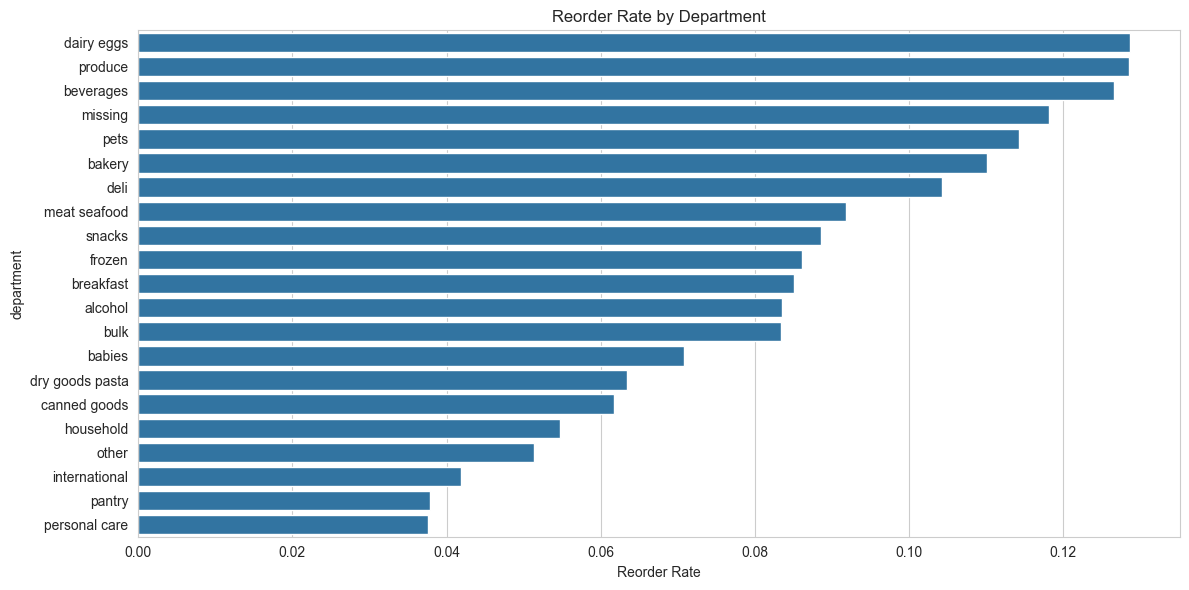

In [5]:
# Department reorder rates
dept_reorder_analysis = train_with_products.groupby('department').agg({
    'reordered': ['sum', 'count', 'mean']
}).reset_index()

dept_reorder_analysis.columns = ['department', 'reorders', 'total_occurrences', 'reorder_rate']
dept_reorder_analysis = dept_reorder_analysis.sort_values('reorder_rate', ascending=False)

print("Reorder rates by department:")
print(dept_reorder_analysis)

# Visualize
fig, ax = plt.subplots(figsize=(12, 6))
sns.barplot(data=dept_reorder_analysis, x='reorder_rate', y='department', ax=ax)
ax.set_xlabel('Reorder Rate')
ax.set_title('Reorder Rate by Department')
plt.tight_layout()
plt.show()

In [6]:
# Segment users by their behavior in training data
user_segments = train_data.groupby('user_id').agg({
    'user_total_orders': 'first',
    'user_reorder_rate': 'first',
    'user_avg_basket_size': 'first',
    'user_total_products': 'first'
}).reset_index()

# Create segments
user_segments['shopping_frequency'] = pd.cut(user_segments['user_total_orders'], 
                                              bins=[0, 5, 10, 20, 100], 
                                              labels=['Infrequent (3-5)', 'Moderate (6-10)', 'Frequent (11-20)', 'Very Frequent (21+)'])

user_segments['loyalty'] = pd.cut(user_segments['user_reorder_rate'], 
                                  bins=[0, 0.3, 0.5, 0.7, 1.0], 
                                  labels=['Exploratory (<30%)', 'Mixed (30-50%)', 'Loyal (50-70%)', 'Very Loyal (70%+)'])

print("User segments by shopping frequency:")
print(user_segments['shopping_frequency'].value_counts().sort_index())
print("\nUser segments by loyalty:")
print(user_segments['loyalty'].value_counts().sort_index())

User segments by shopping frequency:
shopping_frequency
Infrequent (3-5)       38076
Moderate (6-10)        33321
Frequent (11-20)       29317
Very Frequent (21+)    30495
Name: count, dtype: int64

User segments by loyalty:
loyalty
Exploratory (<30%)    37324
Mixed (30-50%)        41411
Loyal (50-70%)        34744
Very Loyal (70%+)     15788
Name: count, dtype: int64


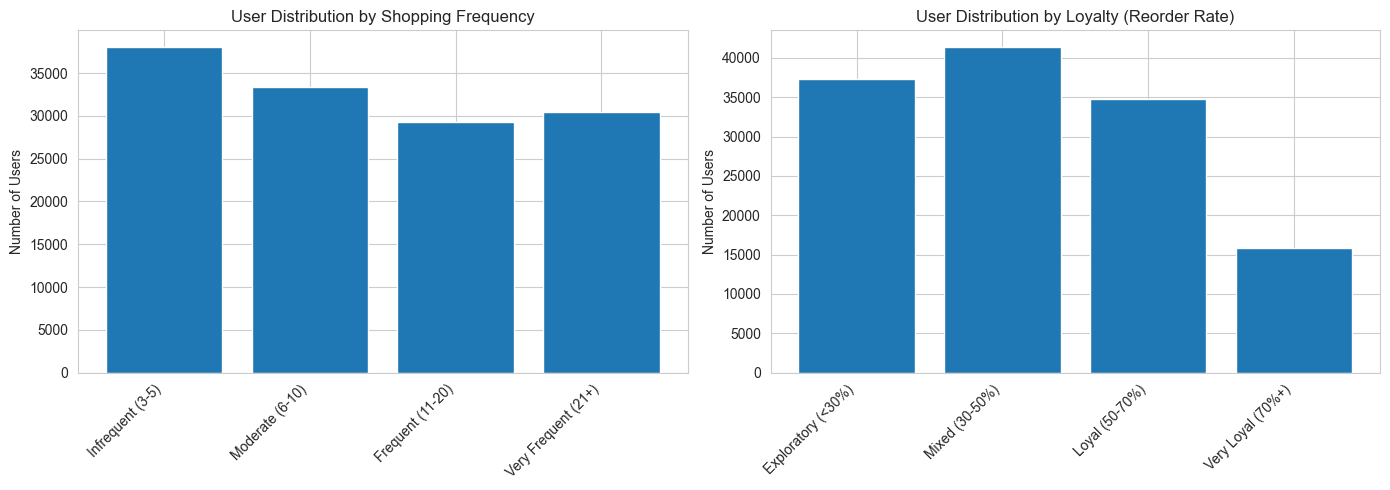

Total users analyzed: 131,209


In [7]:
# Create 2x2 grid for segments
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Shopping frequency
freq_counts = user_segments['shopping_frequency'].value_counts().sort_index()
axes[0].bar(range(len(freq_counts)), freq_counts.values)
axes[0].set_xticks(range(len(freq_counts)))
axes[0].set_xticklabels(freq_counts.index, rotation=45, ha='right')
axes[0].set_ylabel('Number of Users')
axes[0].set_title('User Distribution by Shopping Frequency')

# Loyalty
loyalty_counts = user_segments['loyalty'].value_counts().sort_index()
axes[1].bar(range(len(loyalty_counts)), loyalty_counts.values)
axes[1].set_xticks(range(len(loyalty_counts)))
axes[1].set_xticklabels(loyalty_counts.index, rotation=45, ha='right')
axes[1].set_ylabel('Number of Users')
axes[1].set_title('User Distribution by Loyalty (Reorder Rate)')

plt.tight_layout()
plt.show()

print(f"Total users analyzed: {len(user_segments):,}")

In [8]:
# Get top predictions for a sample user
sample_user_id = test_predictions_full['user_id'].iloc[0]

user_predictions = test_predictions_full[test_predictions_full['user_id'] == sample_user_id].sort_values(
    'reorder_probability', ascending=False
).head(10)

print(f"Top 10 predicted reorders for User {sample_user_id}:")
print(user_predictions[['product_name', 'department', 'reorder_probability']])

Top 10 predicted reorders for User 45082:
                                              product_name department  \
3111964                                             Banana    produce   
472206                                  Raisin Bran Cereal  breakfast   
1382589                               Organic Blackberries    produce   
3111965                                  Deluxe Mixed Nuts     snacks   
3111966                                        Blueberries     frozen   
472203                                  Honey Nut Cheerios  breakfast   
4037853  Pretzel Crisps Original Deli Style Pretzel Cra...     snacks   
4569850                                 Small Hass Avocado    produce   
4569846                            Coconut Sparkling Water  beverages   
472205           Original Nooks & Crannies English Muffins     bakery   

         reorder_probability  
3111964             0.792531  
472206              0.773692  
1382589             0.733231  
3111965             0.732247  

In [9]:
# Calculate segment characteristics
segment_analysis = user_segments.groupby(['shopping_frequency', 'loyalty']).agg({
    'user_id': 'count',
    'user_avg_basket_size': 'mean',
    'user_total_products': 'mean'
}).round(2)

segment_analysis.columns = ['user_count', 'avg_basket_size', 'avg_products_tried']
segment_analysis = segment_analysis.reset_index()

print("Segment Analysis (Top 10 segments by size):")
print(segment_analysis.sort_values('user_count', ascending=False).head(10))

Segment Analysis (Top 10 segments by size):
     shopping_frequency             loyalty  user_count  avg_basket_size  \
0      Infrequent (3-5)  Exploratory (<30%)       23661             9.79   
5       Moderate (6-10)      Mixed (30-50%)       15401            10.49   
14  Very Frequent (21+)      Loyal (50-70%)       13930            10.09   
10     Frequent (11-20)      Loyal (50-70%)       12426            11.14   
15  Very Frequent (21+)   Very Loyal (70%+)       12394            11.24   
9      Frequent (11-20)      Mixed (30-50%)       11513             9.71   
1      Infrequent (3-5)      Mixed (30-50%)       10640            10.43   
4       Moderate (6-10)  Exploratory (<30%)       10525             8.65   
6       Moderate (6-10)      Loyal (50-70%)        6620            10.79   
13  Very Frequent (21+)      Mixed (30-50%)        3857             8.24   

    avg_products_tried  
0                36.74  
5                81.22  
14              349.75  
10              167

C:\Users\drrahman\AppData\Local\Temp\ipykernel_66884\3797691406.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  segment_analysis = user_segments.groupby(['shopping_frequency', 'loyalty']).agg({


In [11]:
# Create honest, data-driven recommendations
recommendations_real = {
    'Segment': [
        'Infrequent + Exploratory (23,661 users)',
        'Moderate + Mixed (15,401 users)', 
        'Very Frequent + Loyal (13,930 users)',
        'Very Frequent + Very Loyal (12,394 users)'
    ],
    'Avg Basket': [9.79, 10.49, 10.09, 11.24],
    'Avg Products Tried': [37, 81, 350, 523],
    'Action': [
        'Product discovery campaigns',
        'Increase shopping frequency',
        'Maintain satisfaction',
        'Expand basket size'
    ],
    'Opportunity': [
        'Convert to regular shoppers',
        'Largest segment to activate',
        'High reorder rate to leverage',
        'Highest basket value to grow'
    ]
}

rec_real = pd.DataFrame(recommendations_real)
print("Data-Driven Segment Strategies:")
print(rec_real)

Data-Driven Segment Strategies:
                                     Segment  Avg Basket  Avg Products Tried  \
0    Infrequent + Exploratory (23,661 users)        9.79                  37   
1            Moderate + Mixed (15,401 users)       10.49                  81   
2       Very Frequent + Loyal (13,930 users)       10.09                 350   
3  Very Frequent + Very Loyal (12,394 users)       11.24                 523   

                        Action                    Opportunity  
0  Product discovery campaigns    Convert to regular shoppers  
1  Increase shopping frequency    Largest segment to activate  
2        Maintain satisfaction  High reorder rate to leverage  
3           Expand basket size   Highest basket value to grow  


In [12]:
# Save key datasets for dashboard
test_predictions_full.to_csv('../data/processed/predictions_with_details.csv', index=False)
dept_reorder_analysis.to_csv('../data/processed/department_reorder_rates.csv', index=False)
product_reorder_analysis.to_csv('../data/processed/product_reorder_rates.csv', index=False)
segment_analysis.to_csv('../data/processed/user_segments.csv', index=False)
rec_real.to_csv('../data/processed/segment_recommendations.csv', index=False)

print("✓ All dashboard data saved:")
print("  - predictions_with_details.csv")
print("  - department_reorder_rates.csv")
print("  - product_reorder_rates.csv")
print("  - user_segments.csv")
print("  - segment_recommendations.csv")

✓ All dashboard data saved:
  - predictions_with_details.csv
  - department_reorder_rates.csv
  - product_reorder_rates.csv
  - user_segments.csv
  - segment_recommendations.csv
